#Welcome to the Drivable Area Detection Project!

* Course: https://jeremycohen.podia.com/image-segmentation

In this project, you will train a Deep Learning algorithm to detect Drivable Area.
You will work on 3 aspects of the segmentation algorithm:
1. [Data Collection](#Data)
2. [Model Definition & Training](#Model)
3. [Model Run in a real-time video feed](#Video)



**GPU**<p>
This shouldn't be needed. You can run it just in case.<p>
Know that Colab uses Tensorflow 2.0 that included Keras.<p>
Be sure to use GPU environment by selecting **Runtime** > **GPU** above.

In [ ]:
## USE GPU
import tensorflow as tf
from tensorflow.python.client import device_lib
# LIST GPUS AVAILABLE
print(device_lib.list_local_devices())
import tensorflow.python.keras
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
tensorflow.python.keras.backend.set_session(sess)

# <a name="Data"></a>1. Data Collect, Visualization, Augmentation

This project will use the [BDD 100K Dataset](https://bdd-data.berkeley.edu/).<p>

It was downloaded from [this website](https://bdd-data.berkeley.edu/login.html) and then dumped into a pickle file.<p>-<p>

If you want to repeat the process, go to the [download page](https://bdd-data.berkeley.edu/portal.html#download) (once logged in) and click on the buttons **Images** and **Driverable Maps** under the BDD100K section.
It will download the necessary dataset. Then pick a subset of it.
Use Google Chrome and in case it doesn't work, hit the button again until it does.<p>-<p>


**Use the provided pickle file**<p>
I have downloaded the images and labels. It took a few hours.<p>
I selected **3,000 images** and **their associated labels** and put them into **2 separate pickle files**. <p>Each image has been resized to **160x80** for memory reasons. <p>
**Original 1280x720** images are also available in the course.

<p>-<p>In this part you will load the dataset and adapt it so it fits your neural network.

## Load the Dataset, Visualize Images & Labels


**Library Import**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle

**Load the Pickle files**

In [2]:
with open("../segmentation_dataset/images_3000_original.p", 'rb') as f:
    images = pickle.load(f)

with open("../segmentation_dataset/labels_3000_original_2_REDUCED.p","rb") as f:
    labels = pickle.load(f)

## NOTE : File has been pickle.dump() with Python 2 so this syntax is necessary to open it with Python 3. Otherwise the following would be enough :
#images = pickle.load(open("images.p","rb", encoding='latin1)) # Pickle Dump using Python 2
#images = pickle.load(open("images.p","rb")) ## Pickle Dump using Python 3

In [3]:
import re

def reduce_label_data(label_path):
    with open(label_path, 'rb') as f:
        labels = pickle.load(f)
    
    # reduce memory via dtype and packbits
    for i, label in enumerate(labels):
        labels[i] = np.packbits(labels[i].astype(np.bool_))

    # save to new location
    label_path_save = re.sub('\.p', '_REDUCED.p', label_path)
    with open(label_path_save, 'wb') as f_obj:
        pickle.dump(labels, f_obj)

In [74]:
# reduce_label_data("../segmentation_dataset/labels_3000_original_2.p")

**Display a random image and its label**<p>
Print dataset information

Text(0.5, 1.0, 'Label')

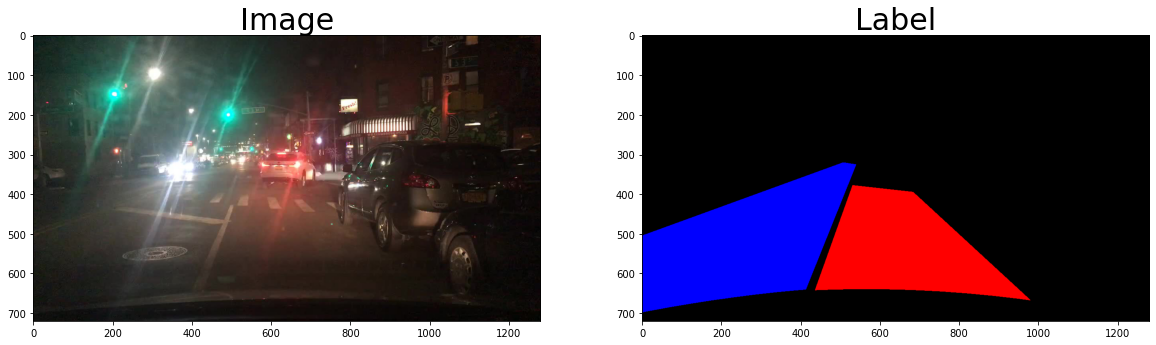

In [19]:
import random
index = random.randint(0,len(labels))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(images[index].squeeze())
ax1.set_title('Image', fontsize=30)
label = np.unpackbits(labels[index], count=2764800).reshape((720, 1280, 3)).astype(np.float32)
ax2.imshow(label)
ax2.set_title('Label', fontsize=30)

In [20]:
print("There are "+ str(len(images))+ " images and "+ str(len(labels)) +" labels in the dataset")
print("Shape of an image")
print(images[0].shape)
print("Shape of a Label")
print(label.shape)
print("Images range from "+str(np.amin(images[0]))+" to "+str(np.amax(images[0])))
print("Labels range from "+str(np.amin(labels[0]))+" to "+str(np.amax(labels[0])))

There are 3000 images and 1500 labels in the dataset
Shape of an image
(720, 1280, 3)
Shape of a Label
(720, 1280, 3)
Images range from 0 to 255
Labels range from 0 to 146


## Labels & Output


To fit an Encoder-Decoder Neural Network; you will need to preprocess your labels. Currently, **your labels are RGB images of dimension 160x80x3.**

As you can see here, we have multiple options, and I will detail all 3 of them.<p>
![Texte alternatif…](http://ronny.rest/media/tutorials/segmentation/ZZZ_IMAGES_DIR/label_formats.jpeg)


*   **A- Class Labels**
Each Pixel is a number representing a class.<p>
In this case, the output is simply a matrix of 1 channel with these numbers.
*   **B- RGB Mappings**
This is what we currently have, the labels are in RGB format.<p>
As we are only working with 2 classes, and they all are colored either red or blue, it's quite easy to work with.
If you ever get more classes, let's say 7, some pixels will not be 0 or 255, they will have some intensity value and it will get more complicated.
Preprocessing is therefore necessary.
*   **C- One Hot Vectors**
Similar to format A, but one-hot encoded.


**Your Choice**

For this project, you have the choice to detect only the driveable area or the driveable area + the adjacent lanes. <p>

You will therefore
*   Remove every blue pixel and face a 1-channel problem (driveable area detection)
*   Keep the blue pixel, use 3 channels.<p>**One easy solution would be to convert every black pixel into a green one.**
Then, the network would have to label a pixel as either green (background), red (driveable), or blue (adjacent).


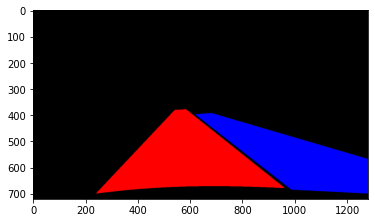

In [21]:
## YOUR CODE HERE
## Preprocess the labels to either remove the blue channel or convert the black pixels into green pixels.
## You can also convert the labels into a matrix (Option A previously showed)

label = np.unpackbits(labels[0], count=2764800).reshape((720, 1280, 3)).astype(np.float32)
label.shape
plt.imshow(label)

For the data augmentation we wil convert black pixel into green pixels for the background

In [4]:
import gc 

def process_labels(labels):
    ''' Changes label image to have a green background. Drivable areas remain red 
        and side lanes remain blue
        '''
    processed_labels = []
    for label in labels:
        label_copy = np.unpackbits(label, count=2764800).reshape((720, 1280, 3)).copy()
        label_copy[:, :, 1] = np.logical_not(np.logical_or(label_copy[:, :, 0], 
                                                           label_copy[:, :, 2]))
        processed_labels.append(label_copy)

        gc.collect()

    return processed_labels

In [5]:
# get processed labels
processed_labels = process_labels(labels)

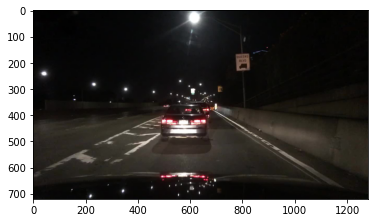

In [11]:
plt.imshow(images[1510])

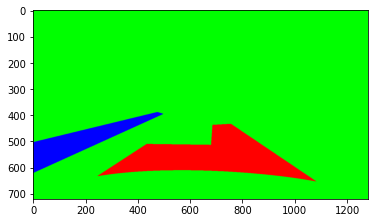

In [10]:
plt.imshow(processed_labels[10].astype(float))

In [8]:
# save processed labels to disk
reduced_processed_labels = []
for i, label in enumerate(processed_labels):
        reduced_processed_labels.append(np.packbits(label.astype(np.bool_)))

        gc.collect()

In [9]:
with open("../segmentation_dataset/processed_labels_3000_original_2_REDUCED.p", 'wb') as f_obj:
        pickle.dump(reduced_processed_labels, f_obj)

In [68]:
del reduced_processed_labels

**Data Augmentation**

3,000 images can be enough, but in Deep Learning, **more is better**.
If you want a strong model performance, feel free to augment your dataset any way you want.

6000
6000


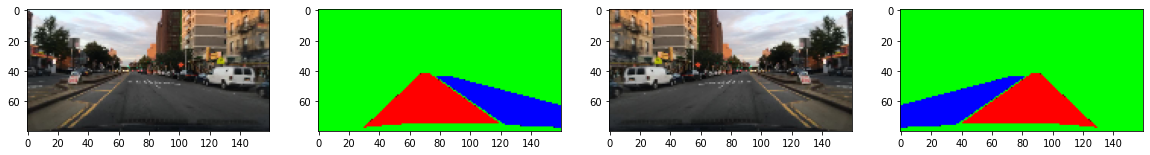

In [ ]:
## YOUR CODE HERE
## Augment your images if you think it's necessary
## Below is an example of flipping the image to double the size of the dataset

#### Use opencv2 to augment the data

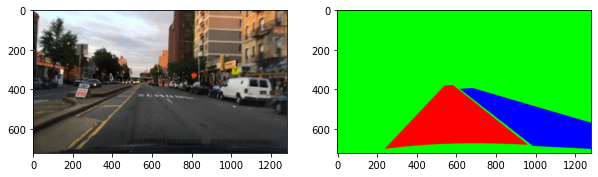

In [116]:
import cv2 
image = images[0]
# label = np.unpackbits(labels[0], count=2764800).reshape((720, 1280, 3))
label = processed_labels[0]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image)
ax2.imshow(label.astype(float));

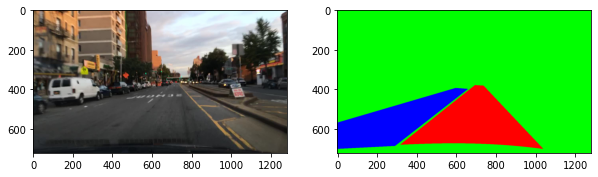

In [117]:
# flip across vertical axis
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(cv2.flip(image, 1))
ax2.imshow(cv2.flip(label, 1).astype(float))

In [118]:
def random_rotate(image, label, angle=45):
    ''' Applys random rotation to image and label. Leaves part of the the 
        image cropped out which is desireable for this scenario since
        it further diversifies the data
        '''
    center = (image.shape[1] // 2, image.shape[0] // 2)
    angle = np.random.uniform(-angle, angle)
    rot = cv2.getRotationMatrix2D(center, angle, scale=1)
    rotated_image = cv2.warpAffine(image, rot, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    rotated_label = cv2.warpAffine(label, rot, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return rotated_image, rotated_label

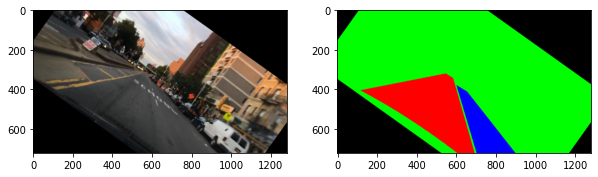

In [119]:
rotated_image, rotated_label = random_rotate(image, label, angle=45)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(rotated_image)
ax2.imshow(rotated_label.astype(float));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


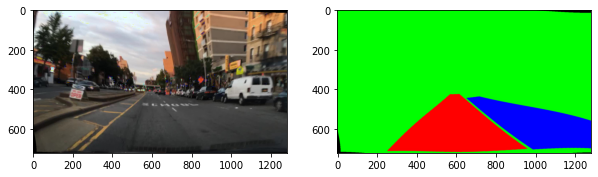

In [128]:
import elasticdeform

[deformed_image, deformed_label] = elasticdeform.deform_random_grid([image, label.astype(np.float32)], axis=(0, 1))
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(deformed_image)
ax2.imshow(deformed_label) # .astype(float));

In [133]:
# Now apply augmentations to the data
augmented_images = []
augmented_labels = []
for image, label in zip(images, processed_labels):
    # perform random horizotnal flip
    if np.random.uniform(0, 1) >= 0.5:
        image = cv2.flip(image, 1)
        label = cv2.flip(label, 1)

    # perform elastic deformation
    [deformed_image, deformed_label] = elasticdeform.deform_random_grid([image, label.astype(np.float32)], 
                                                                        axis=(0, 1))

    # perform random rotation and "crop" (it's a feature!)
    rotated_image, rotated_label = random_rotate(deformed_image, deformed_label, angle=25)

    augmented_images.append(rotated_image.astype(np.uint8))
    augmented_labels.append(rotated_label.astype(np.float32))

    gc.collect()

In [136]:
del images

In [137]:
# save augmented data
with open("../segmentation_dataset/augmented_images_3000_original.p", 'wb') as f_obj:
        pickle.dump(augmented_images, f_obj)

reduced_augmented_labels = []
for i, label in enumerate(augmented_labels):
        reduced_augmented_labels.append(np.packbits(label.astype(np.bool_)))
        gc.collect()

with open("../segmentation_dataset/augmented_labels_3000_original_1_REDUCED.p", 'wb') as f_obj:
        pickle.dump(reduced_augmented_labels, f_obj)

KeyboardInterrupt: 

new method, just use images, the pickle files don't save us any memory expect for labels since they can be compressed

https://stackoverflow.com/questions/50268092/save-1-bit-deep-binary-image-in-python

**Train Test Split**<p>
As for every neural network, you will need **training** and **testing** data.

For the total dataset we will combine the 50% of the unagumented data and use the remaining 50% and augmented data for training. Possible validate on 35% of the original dataset and test on the remaining 15% of the data.

Need to find out how to load data from disk durng training

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
## YOUR CODE HERE
## SPLIT THE DATASET

# <a name="Model"></a>2. Create A Deep Learning Model


## Model Definition

Here, we will define a Fully Convolutional Neural Network.<p>
It actually means a **neural networks that doesn't have any Dense layer** (or Fully Connected), but **only Convolutions**.

![Texte alternatif…](https://mi.eng.cam.ac.uk/projects/segnet/images/segnet.png)

We will use **Keras**.<p>
[Here is a way to use Keras for Deep Learning](https://keras.io/getting-started/functional-api-guide/).

**What should we implement?**


1.   Create an **encoder** that learns the features
2.   Create a **decoder** that upsamples to the original image size
3.   Implement advanced techniques such as **1x1 convolutions**, or **skip connections** to make the neural network better.

To avoid overfitting, we can use **Dropout**.
To make the network better, we can use **Batch Normalization** after the input. In semantic segmentation, Batch Normalization have proven amazing results.

Feel free to explore as you build your model.
You can also build a model from existing models.

*   [UNet](https://arxiv.org/pdf/1505.04597.pdf)
*   [SegNet](https://arxiv.org/pdf/1511.00561.pdf)
*   [FCN](https://arxiv.org/pdf/1411.4038.pdf)
*   [DeepLab](https://arxiv.org/pdf/1606.00915.pdf)





**Imports**

In [ ]:
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Activation, Dropout, Conv2D, MaxPooling2D, Reshape, Input, add
from tensorflow.python.keras.layers import UpSampling2D, Conv2DTranspose
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers

**Build your Model**

In [19]:
def simple_encoder_decoder():
    """
    Try a simple Encoder-Decoder architecture.
    Use Convolutions, Transposed Convolutions.
    Use Pooling, Unpooling or UpSampling.
    GOAL: Match the output to the input. Experiment.
    """
    ## YOUR CODE HERE
    input_x = Input(shape=(80,160,3))
    x = BatchNormalization(input_shape=(80,160,3))(input_x)
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x1 = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x1)
    x = UpSampling2D(interpolation='bilinear')(x)
    x = add([x1, x])
    x = Conv2DTranspose(32,(3,3),strides=(1,1), padding='valid', activation='relu')(x)
    x = Conv2D(3, (1,1), strides=(1,1), padding='valid',activation='softmax')(x)
    return Model(input_x,x)

model = simple_encoder_decoder() 
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 80, 160, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 80, 160, 3)   12          input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 78, 158, 32)  896         batch_normalization_8[0][0]      
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 78, 158, 32)  128         conv2d_4[0][0]                   
____________________________________________________________________________________________

## MODEL TRAINING

Use any technique you know to improve model training or generalization.


*   If you want to detect **1 class (driveable area)**, you can use **binary cross-entropy or mean squared error** as a metric.
*  If you want to detect **2 or more classes** (driveable area + adjacent), you can use **categorical cross-entropy** as a metric. <p>

You are free to use any optimizer you want.

**Hyperparameters**

In [ ]:
batch_size = 
epochs = 
pool_size = 
learning_rate = 
steps_per_epoch = 
input_shape = X_train.shape[1:]

**Training**

In [ ]:
# Using a generator to help the model use less data
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

# Compiling and training the model
model.compile()
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=steps_per_epoch, 
          epochs=epochs, verbose=1, learning_rate=learning_rate, validation_data=(X_val, y_val))
# Freeze layers since training is done

# Save model architecture and weights
model.save('model.h5')

**Plot Training Results**

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Test the model and Build a general pipeline

In [ ]:
def rgb_channel(img, thresholding=False, thresh=230):
    """Threshold the re-drawn images
    Returns R, G, B channels"""
    image = np.copy(img)
    if thresholding:
        ret, image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    return R,G,B

**Build the Run Function**
The run function must:
* Take an image as input
* Resize the input to match the model size
* Call model.predict()
* Extract R,G,B channels from prediction
* Rescale to the original image size
* Draw on the input image
* Return the result

In [ ]:
def run(input_image):
    ## YOUR CODE HERE
    pass

**Test from the dataset**

Text(0.5, 1.0, 'Drawn Prediction')

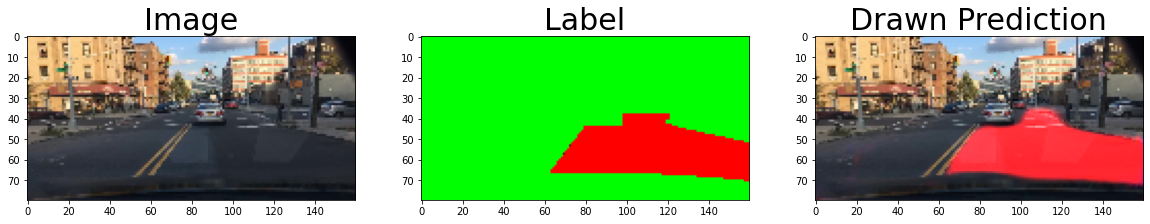

In [ ]:
index = random.randint(0,len(images))

img_test = run(images[index])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(images[index].squeeze())
ax1.set_title('Image', fontsize=30)
ax2.imshow(labels[index].squeeze())
ax2.set_title('Label', fontsize=30)
ax3.imshow(img_test)
ax3.set_title("Drawn Prediction", fontsize=30)

**Test on a never seen image**

In [ ]:
predict_image = mpimg.imread("yourpathhere")
plt.imshow(run(predict_image))
plt.show()

# <a name="Video"></a>3. Run on a Video

Here is the best part. FCN models generally are fast. They can run on CPU at 5 FPS and on GPU at a very high frame rate.<p>
Test your code on a video and see how it worked.

In [ ]:
from moviepy.editor import VideoFileClip
video_file = "/content/drive/My Drive/video_path_here"
clip = VideoFileClip(video_file).subclip(0,30).set_fps(15)
white_clip = clip.fl_image(run)
%time white_clip.write_videofile("output.mp4",audio=False)

**Costa Rica Challenge**<p>
Try your algorithm on Costa Rica roads!
Use the files **costa_rica_challenge** and **costa_rica_challenge_2** provided.<P>
/!\ video was taken from an iPhone X at 60 FPS and 4K resolution...

In [ ]:
## VIDEO IS TAKEN AT 60 FPS ON 4K RESOLUTION; NO IMAGE DISTORTION CORRECTION IS DONE
## THE PROGRAM HERE RUNS ON CPU AT 2 FPS; RUN ON YOUR OWN MACHINE FOR BETTER PERFORMANCE
